<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Using-all-available-baseline-lengths" data-toc-modified-id="Using-all-available-baseline-lengths-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Using all available baseline lengths</a></span></li><li><span><a href="#Using-only-short-baselines" data-toc-modified-id="Using-only-short-baselines-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Using only short baselines</a></span></li></ul></div>

In [1]:
import numpy as np

#from redshifted_gaussian_fields import generator

import glob, os, h5py, copy
import time

#from RIMEz import sky_models, beam_models, rime_funcs, utils, management

In [2]:
import pyuvdata

In [3]:
import matplotlib.pyplot as plt

In [15]:
import hera_pspec as hp

In [84]:
working_dir = '/lustre/aoc/projects/hera/zmartino/hera_validation/H4C_IDR2_signal_sim/'

In [85]:
vis_fmode_file_path = working_dir + 'vis_sim_test.rimezh5'

In [86]:
VC = management.VisibilityCalculation(restore_file_path=vis_fmode_file_path)
VC.calculation_method = 'harmonics'

In [87]:
jd0 = VC.initial_time_sample_jd

era_init = 2*np.pi - utils.HERA_LON + 2*2*np.pi/86164.

initial_time_sample_jd = utils.era2JD(era_init, 2459853.5)

omega_e = 7.292115e-5 # rad per sec
integration_time = VC.integration_time
integration_time_rad = omega_e * integration_time

Nt = int((2*np.pi)/omega_e / 5)
delta_era_axis = integration_time_rad * np.arange(-Nt//2,Nt//2+1)
delta_era_axis = delta_era_axis[::100]

In [88]:
era_axis = utils.JD2era_tot(jd0) + delta_era_axis
time_sample_jds = np.array(list(map(lambda era: utils.era2JD(era, jd0), era_axis)))

In [89]:
era_axis.shape

(173,)

In [90]:
VC.integration_time

4.986333847045898

In [91]:
antpos = {a:r for a,r in zip(VC.antenna_numbers, VC.antenna_positions_meters)}

In [92]:
baselines = [antpos[jj] - antpos[ii] for ii,jj in VC.antenna_pairs_used]

In [93]:
# Lm = (VC.Vm.shape[2] + 1) //2 

# m_axis = np.arange(-Lm + 1, Lm)

# plt.figure()
# plt.plot(m_axis, VC.Vm[300,0,:,0,0].imag)
# plt.plot(m_axis, -np.flip(VC.Vm[300,0,:,0,0].imag))
# plt.xlim(-50,50)
# plt.show()

# plt.figure()
# plt.plot(np.real(VC.V[:,0,0,1,1]))
# plt.plot(np.imag(VC.V[:,0,0,1,1]))
# plt.show()

In [94]:
%%time
VC.compute_time_series(time_sample_jds=time_sample_jds, integration_time=integration_time)

CPU times: user 1min 6s, sys: 116 ms, total: 1min 6s
Wall time: 9.16 s


In [95]:
antenna_positions = VC.antenna_positions_meters

ant_ind_pairs_used = VC.antenna_pairs_used

antenna_numbers = VC.antenna_numbers

antenna_names = ['HH' + str(a) for a in antenna_numbers]

uvdata_extra_args = {
'antenna_numbers': antenna_numbers,
'antenna_names': antenna_names,
'instrument': 'RIMEz calculation',
'telescope_name': 'HERA',
}

In [96]:
%%time
uvd = VC.to_uvdata(**uvdata_extra_args)

uvd.data_array *= 2.0
uvd.conjugate_bls(convention='ant1<ant2')

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


CPU times: user 1.36 s, sys: 436 ms, total: 1.79 s
Wall time: 2.31 s


In [97]:
# This is the cosmological parameter set in the input simulation
def astropyPlanck15_for_hera_pspec():
    H0 = 67.74
    h = H0/100.

    Om_b = 0.02230/h**2.
    Om_c = 0.1188/h**2.
    Om_L = 0.6911
    Om_k = 1. - (Om_b + Om_c + Om_L)

    hp_cosmo = hp.conversions.Cosmo_Conversions(Om_L=Om_L,
                                                Om_b=Om_b,
                                                Om_c=Om_c,
                                                H0=H0,)
    return hp_cosmo

cosmo = astropyPlanck15_for_hera_pspec()

In [98]:
# Load beam-dependent normalization data
omegas_data_path = '/lustre/aoc/projects/hera/zmartino/hera_calib_model/H4C_1/vivaldi_solid_angle_and_reciever_power.h5'

with h5py.File(omegas_data_path, 'r') as h5f:
    Omega = h5f['directivity_integral'][()]
    Omegapp = h5f['directivity_square_integral'][()]
    
# hera_pspec beam initiated from pre-computed integral data
hpsb = hp.pspecbeam.PSpecBeamFromArray(Omega, Omegapp, uvd.freq_array[0], cosmo=cosmo)

In [99]:
uvd = hp.pstokes.construct_pstokes(uvd, uvd, pstokes='pI', run_check=False)

nu_e = 1420405751.7667 # Hz
nu_hz = uvd.freq_array[0]

ds = hp.PSpecData(dsets=[uvd, uvd], beam=hpsb)
ds.Jy_to_mK()

Cannot convert dset 1 Jy -> mK because vis_units = mK


In [100]:
# get antenna pairs for 63 unique baselines, excluding auto-correlation
ant_pairs = [ant_pair for ant_pair in uvd.get_antpairs() if ant_pair[0] != ant_pair[1]]

# approximate subbands used in H1C IDR2 results
spw_ranges = [(175, 325), (575, 725), (1050, 1200)]

In [101]:
%%time
uvp = ds.pspec(ant_pairs, ant_pairs,
              dsets=(0,1),
              pols=('pI', 'pI'),
              input_data_weight='identity',
              norm='I',
              taper='blackman-harris',
              spw_ranges=spw_ranges,
              store_window=False,
              verbose=True,
              allow_fft=True,
              exact_norm=False)

CPU times: user 38.3 s, sys: 761 ms, total: 39.1 s
Wall time: 17 s


In [102]:
%%time
k_bin_widths = 0.05

k_bins = np.arange(0,2.0,k_bin_widths)

uvp_sphr = copy.deepcopy(uvp)

# time average for each (delay, baseline)
uvp_sphr.average_spectra(time_avg=True, inplace=True)

# average over (delay, baseline) for each k
uvp_sphr = hp.grouping.spherical_average(uvp_sphr, k_bins, k_bin_widths, run_check=False)

CPU times: user 2.4 s, sys: 88.9 ms, total: 2.49 s
Wall time: 362 ms


In [76]:
covariance_data_path = '/lustre/aoc/projects/hera/zmartino/hera_validation/H4C_IDR2_signal_sim/covariance.h5'

gcfg = generator.restore_from_file(covariance_data_path)

In [103]:
def true_power_spectrum(k, z):

    Pk = gcfg.Pspec(cosmo.h * k)
    
    nu_e = 1420405751.7667 # Hz
    nu_z = nu_e/(1. + z)
    
    # redshift dimming factor
    Pk *= (nu_e/nu_z)**-2
    
    # little-h "units"
    Pk *= cosmo.h**3
    
    # K^2 to mK^2
    Pk *= 1e6
    
    return Pk

In [104]:
def get_z_mean(spw):
    spw_freqs = uvp.freq_array[uvp.spw_freq_array == spw]
    return cosmo.f2z(np.mean(spw_freqs))

In [105]:
def get_ks(spw):
    spw_freqs = uvp.freq_array[uvp.spw_freq_array == spw]
    z_s = cosmo.f2z(spw_freqs)
    dr = np.diff(np.array([cosmo.DC(z, little_h=True) for z in z_s]))
    
    return np.pi * np.mean(1/np.abs(dr)), cosmo.f2z(np.mean(spw_freqs))

In [106]:
def tapered_power_spectrum(k, spw):
    z = get_z_mean(spw)
        
    Pk = gcfg.Pspec(cosmo.h * k)
    
    nu_e = 1420405751.7667 # Hz
    nu_z = nu_e/(1. + z)
    
    # redshift dimming factor
    Pk *= (nu_e/nu_z)**-2
    
    # little-h "units"
    Pk *= cosmo.h**3
    
    # K^2 to mK^2
    Pk *= 1e6
    
    spw_freqs = uvp.freq_array[uvp.spw_freq_array == spw]    
    z = cosmo.f2z(np.mean(spw_freqs))
    alpha = cosmo.dRpara_df(z)
    delta_nu = np.median(np.diff(spw_freqs))
    
    x = 0.5 * k * alpha * delta_nu
    taper = np.sinc(x/np.pi)**2
    
    Pk *= taper
    
    return Pk

In [107]:
def expected_power_spectrum(k, spw, nterms=20):
    ks, z = get_ks(spw)
    
    Pk = tapered_power_spectrum(k, spw)
    
    for n in range(1,nterms):
        Pk += tapered_power_spectrum(k + 2*n*ks, spw) + tapered_power_spectrum(k - 2*n*ks, spw)
    
    return Pk

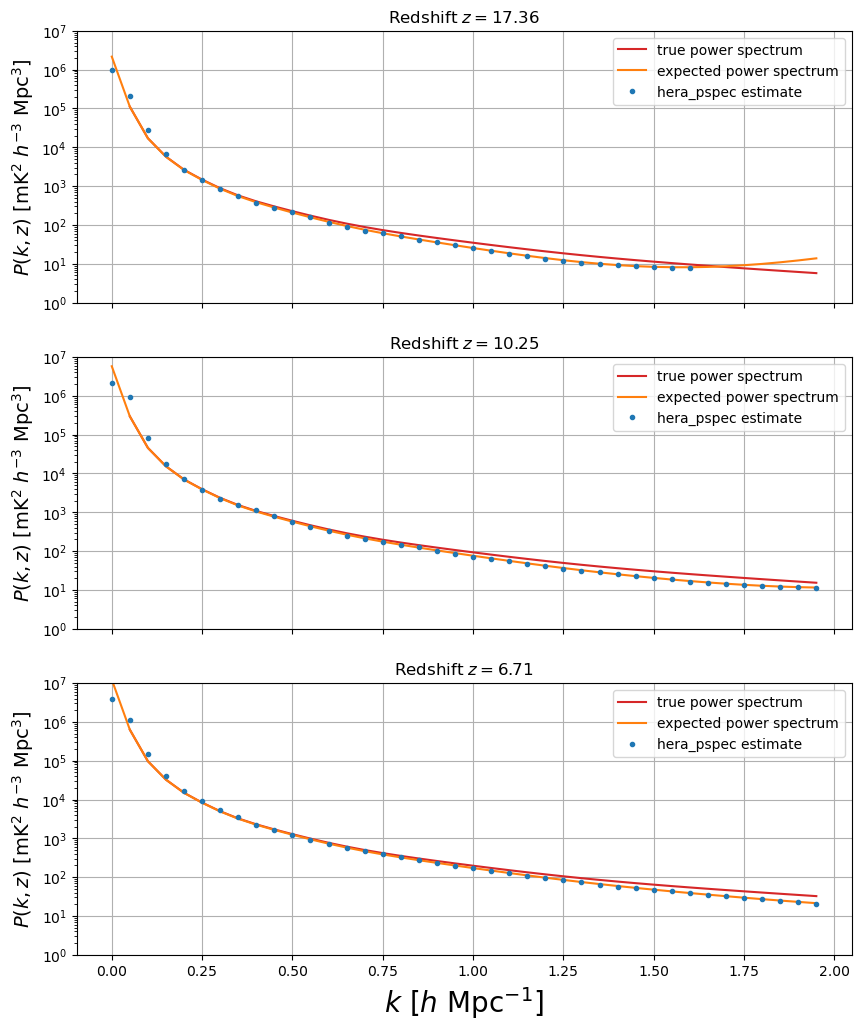

In [108]:
keys = uvp_sphr.get_all_keys()

fig, axes = plt.subplots(3, 1, figsize=(10,12), sharex=True)

for ii, spw in enumerate(uvp_sphr.data_array.keys()):
    pspec_est = uvp_sphr.get_data(keys[spw])[0].real
    
    z_mean = get_z_mean(spw)

    pspec_true = true_power_spectrum(k_bins[1:], z_mean)
    pspec_expected = expected_power_spectrum(k_bins, spw)
    
    ax = axes[ii]
    
    ax.plot(k_bins[1:], pspec_true, label='true power spectrum', color='tab:red')
    ax.plot(k_bins, pspec_expected, label='expected power spectrum', color='tab:orange')
    ax.plot(k_bins, pspec_est, '.', label='hera_pspec estimate', color='tab:blue')

    ax.set_yscale('log')
    ax.set_ylim(1e0, 1e7)
    ax.set_ylabel(r'$P(k,z)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$', fontsize=14)
    
#     ax.set_xscale('log')
#     ax.set_xlim(0.8*k_bins[1], 1.2*k_bins[-1])
    if spw == len(uvp_sphr.data_array.keys()) - 1:
        ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=20)
    ax.set_title(r'Redshift $z =${0}'.format(str(np.around(z_mean,2))))
    
    ax.grid()
    ax.legend()
plt.show()

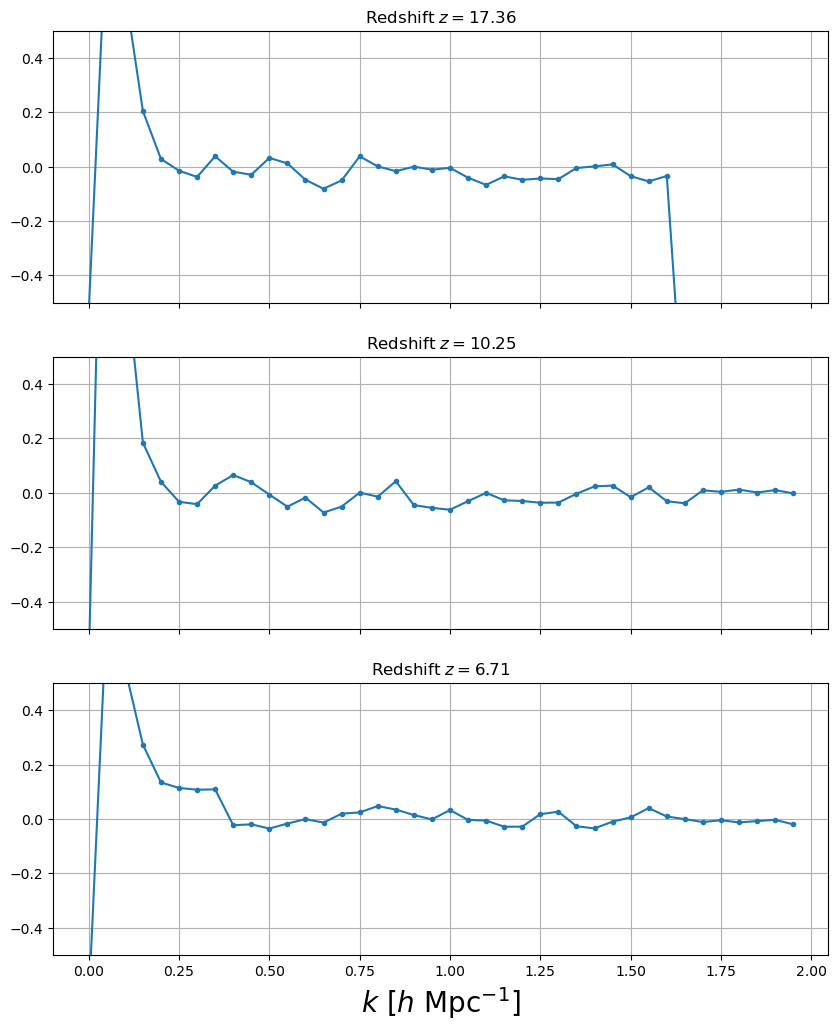

In [109]:
keys = uvp_sphr.get_all_keys()

fig, axes = plt.subplots(3, 1, figsize=(10,12), sharex=True)

for ii, spw in enumerate(uvp_sphr.data_array.keys()):
    pspec_est = uvp_sphr.get_data(keys[spw])[0].real
    
    z_mean = get_z_mean(spw)

    pspec_true = true_power_spectrum(k_bins[1:], z_mean)
    pspec_expected = expected_power_spectrum(k_bins, spw)
    
    ax = axes[ii]
    
    frac_diff = (pspec_est - pspec_expected) / pspec_expected
    
    ax.plot(k_bins, frac_diff, '.-')
    
    ax.set_ylim(-0.5, 0.5)
    
    if spw == len(uvp_sphr.data_array.keys()) - 1:
        ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=20)
    ax.set_title(r'Redshift $z =${0}'.format(str(np.around(z_mean,2))))
    
    ax.grid()
    
plt.show()

# Check H4C validation sim files

In [7]:
h4c_val_file_dir = '../outputs/eor/chunked/'

h4c_val_files = sorted(glob.glob(h4c_val_file_dir + 'zen.LST*.eor.uvh5'))

#h4c_val_files = h4c_val_files[1::50]

In [8]:
len(h4c_val_files)

96

In [9]:
pyuvdata_nocheck = {
    'run_check': False,
    'check_extra': False,
    'run_check_acceptability': False,
    'strict_uvw_antpos_check': False,
    'check_autos': False,
    'fix_autos': False
}

In [ ]:
h4c_uvd = pyuvdata.UVData.from_file(h4c_val_files[0], **pyuvdata_nocheck)
#h4c_uvd.nsample_array = np.ones(h4c_uvd.data_array.shape)

In [27]:
%%time
h4c_uvd = pyuvdata.UVData.from_file(h4c_val_files, axis='blt', **pyuvdata_nocheck)
h4c_uvd.nsample_array[:] = 1.0

CPU times: user 47.9 s, sys: 38.6 s, total: 1min 26s
Wall time: 3min 59s


In [29]:
h4c_uvd.nsample_array.shape

(244622, 1, 1535, 4)

In [30]:
# plt.plot(uvd.get_data((0,18,'pI'))[0,:].real)

In [31]:
# antpos[18] - antpos[0]

In [11]:
h4c_antpos, h4c_antnums = h4c_uvd.get_ENU_antpos()

h4c_antpos = {a:r for a,r in zip(h4c_antnums, h4c_antpos)}

In [12]:
h4c_antpos[0] - h4c_antpos[4]

array([-58.43136953,  -0.22315515,   0.09930224])

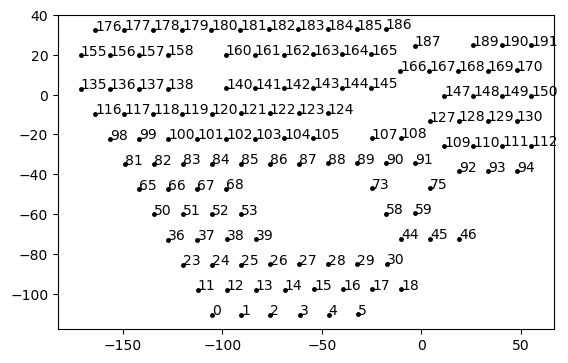

In [13]:
for a,r in h4c_antpos.items():
    plt.plot(r[0], r[1], '.k', ms=5)
    plt.text(r[0], r[1], str(a))
plt.gca().set_aspect('equal')
plt.show()

In [35]:
# plt.plot(h4c_uvd.get_data((4,0,'pI'))[0,:].real)

In [16]:
h4c_uvd = hp.pstokes.construct_pstokes(h4c_uvd, h4c_uvd, pstokes='pI', run_check=False)

nu_e = 1420405751.7667 # Hz
nu_hz = h4c_uvd.freq_array[0]

h4c_ds = hp.PSpecData(dsets=[h4c_uvd, h4c_uvd], beam=hpsb)
h4c_ds.Jy_to_mK()

The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 359.64564290438364 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 359.64564290438364 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

## Using all available baseline lengths

In [113]:
ant_pairs = [ant_pair for ant_pair in h4c_uvd.get_antpairs() if ant_pair[0] != ant_pair[1]]

spw_ranges = [(175, 325), (575, 725), (1050, 1200)]

In [114]:
%%time
h4c_uvp = h4c_ds.pspec(ant_pairs, ant_pairs,
              dsets=(0,1),
              pols=('pI', 'pI'),
              input_data_weight='identity',
              norm='I',
              taper='blackman-harris',
              spw_ranges=spw_ranges,
              store_window=False,
              verbose=True,
              allow_fft=True,
              exact_norm=False)

CPU times: user 6min, sys: 13.1 s, total: 6min 13s
Wall time: 1min


In [115]:
%%time
k_bin_widths = 0.05

k_bins = np.arange(0,2.0,k_bin_widths)

h4c_uvp_sphr = copy.deepcopy(h4c_uvp)

# time average for each (delay, baseline)
h4c_uvp_sphr.average_spectra(time_avg=True, inplace=True)

# average over (delay, baseline) for each k
h4c_uvp_sphr = hp.grouping.spherical_average(h4c_uvp_sphr, k_bins, k_bin_widths, run_check=False)

CPU times: user 21.4 s, sys: 907 ms, total: 22.3 s
Wall time: 17.9 s


In [116]:
# def get_z_mean(spw):
#     spw_freqs = h4c_uvp.freq_array[h4c_uvp.spw_freq_array == spw]
#     z_s = cosmo.f2z(spw_freqs)
#     return np.median(z_s)

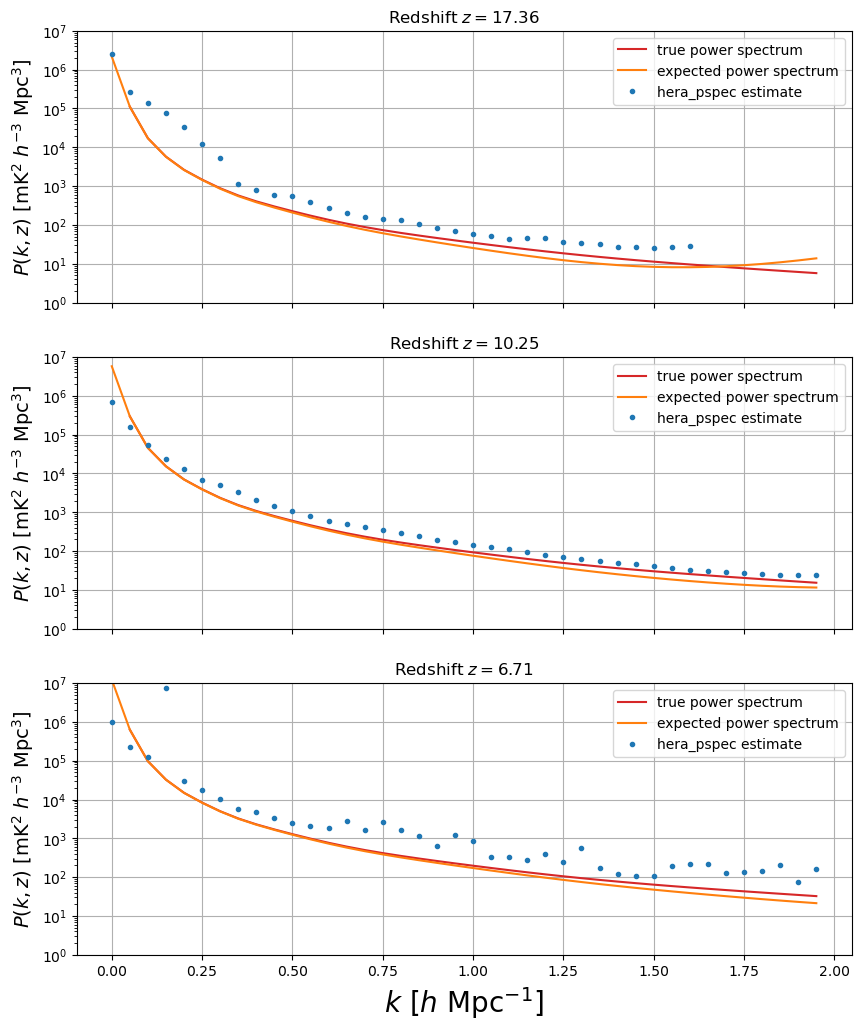

In [117]:
keys = h4c_uvp_sphr.get_all_keys()

fig, axes = plt.subplots(3, 1, figsize=(10,12), sharex=True)

for ii, spw in enumerate(h4c_uvp_sphr.data_array.keys()):
    pspec_est = h4c_uvp_sphr.get_data(keys[spw])[0].real
    
    z_mean = get_z_mean(spw)

    pspec_true = true_power_spectrum(k_bins[1:], z_mean)
    pspec_expected = expected_power_spectrum(k_bins, spw)
    
    ax = axes[ii]
    
    ax.plot(k_bins[1:], pspec_true, label='true power spectrum', color='tab:red')
    ax.plot(k_bins, pspec_expected, label='expected power spectrum', color='tab:orange')
    ax.plot(k_bins, pspec_est, '.', label='hera_pspec estimate', color='tab:blue')

    ax.set_yscale('log')
    ax.set_ylim(1e0, 1e7)
    ax.set_ylabel(r'$P(k,z)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$', fontsize=14)
    
#     ax.set_xscale('log')
#     ax.set_xlim(0.8*k_bins[1], 1.2*k_bins[-1])
    if spw == len(h4c_uvp_sphr.data_array.keys()) - 1:
        ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=20)
    ax.set_title(r'Redshift $z =${0}'.format(str(np.around(z_mean,2))))
    
    ax.grid()
    ax.legend()
plt.show()

## Using only short baselines

In [118]:
def check_bl_length(ap):
    bvec = h4c_antpos[ap[1]] - h4c_antpos[ap[0]]
    return np.linalg.norm(bvec)

In [119]:
ant_pairs = [ant_pair for ant_pair in h4c_uvd.get_antpairs() if ant_pair[0] != ant_pair[1] and check_bl_length(ant_pair) <= 58.8]

spw_ranges = [(175, 325), (575, 725), (1050, 1200)]

In [120]:
%%time
h4c_uvp = h4c_ds.pspec(ant_pairs, ant_pairs,
              dsets=(0,1),
              pols=('pI', 'pI'),
              input_data_weight='identity',
              norm='I',
              taper='blackman-harris',
              spw_ranges=spw_ranges,
              store_window=False,
              verbose=True,
              allow_fft=True,
              exact_norm=False)

CPU times: user 1min 10s, sys: 1.91 s, total: 1min 12s
Wall time: 21.5 s


In [121]:
%%time
k_bin_widths = 0.05

k_bins = np.arange(0,2.0,k_bin_widths)

h4c_uvp_sphr = copy.deepcopy(h4c_uvp)

# time average for each (delay, baseline)
h4c_uvp_sphr.average_spectra(time_avg=True, inplace=True)

# average over (delay, baseline) for each k
h4c_uvp_sphr = hp.grouping.spherical_average(h4c_uvp_sphr, k_bins, k_bin_widths, run_check=False)

CPU times: user 3.84 s, sys: 186 ms, total: 4.02 s
Wall time: 1.21 s


In [122]:
# def get_z_mean(spw):
#     spw_freqs = h4c_uvp.freq_array[h4c_uvp.spw_freq_array == spw]
#     z_s = cosmo.f2z(spw_freqs)
#     return np.median(z_s)

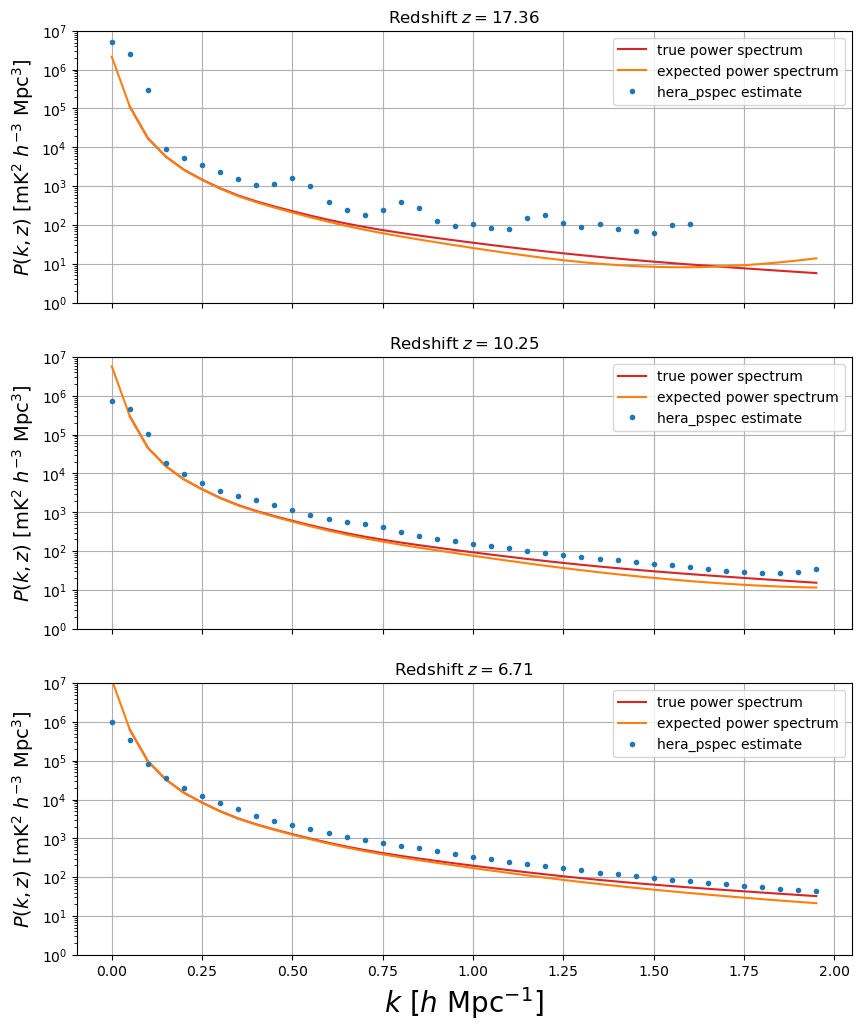

In [123]:
keys = h4c_uvp_sphr.get_all_keys()

fig, axes = plt.subplots(3, 1, figsize=(10,12), sharex=True)

for ii, spw in enumerate(h4c_uvp_sphr.data_array.keys()):
    pspec_est = h4c_uvp_sphr.get_data(keys[spw])[0].real
    
    z_mean = get_z_mean(spw)

    pspec_true = true_power_spectrum(k_bins[1:], z_mean)
    pspec_expected = expected_power_spectrum(k_bins, spw)
    
    ax = axes[ii]
    
    ax.plot(k_bins[1:], pspec_true, label='true power spectrum', color='tab:red')
    ax.plot(k_bins, pspec_expected, label='expected power spectrum', color='tab:orange')
    ax.plot(k_bins, pspec_est, '.', label='hera_pspec estimate', color='tab:blue')

    ax.set_yscale('log')
    ax.set_ylim(1e0, 1e7)
    ax.set_ylabel(r'$P(k,z)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$', fontsize=14)
    
#     ax.set_xscale('log')
#     ax.set_xlim(0.8*k_bins[1], 1.2*k_bins[-1])
    if spw == len(h4c_uvp_sphr.data_array.keys()) - 1:
        ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=20)
    ax.set_title(r'Redshift $z =${0}'.format(str(np.around(z_mean,2))))
    
    ax.grid()
    ax.legend()
plt.show()